# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

<b>Признаки</b>
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

<br><b> Целевой признак </b>
* Price — цена (евро)

## Предисловие

Это дополнительный проект по датасету с выгрузкой объявлений о продаже авто. В основном проекте проверялось много моделей и различные варианты предобработки данных и в итоге он получился слишком большим. Чтобы добавить проект в портфолио решил сделать более лаконичное решение, заодно немного упростил подход к предобработке, добавил чуть больше визуализации, добавил пару новых признаков и усреднил предикты новых моделей, получив более высокий скор. При этом здесь будут использованы только 3 алгоритма (Catboost, LightGBM, RF), а результаты работы других алгоритмов из основного проекта будут отражены в общем отчете в конце.

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

Загрузим и изучим данные:

In [2]:
df = pd.read_csv('D:\data_auto.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
df_info=df_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
df_info=df_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                             rename(index={0:'null values (%)'}))
display(df_info)
print('Размер датасета:', df.shape)
display(df[:5])
print('Количество дубликатов:', df.duplicated().sum())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
column type,object,int64,object,int64,object,int64,object,int64,int64,object,object,object,object,int64,int64,object
null values (nb),0,0,37490,0,19833,0,19705,0,0,32895,0,71154,0,0,0,0
null values (%),0,0,10.5794,0,5.59671,0,5.56059,0,0,9.2827,0,20.0791,0,0,0,0


Размер датасета: (354369, 16)


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Количество дубликатов: 4


В загруженном датасете 16 столбцов и 354369 строк. В нём представлены анкеты пользователей о продаже автомобилей. В качестве признаков приведены различиные характериски авто. Целевым признаком для моделирования является цена. В данных довольно много пропусков: в VehicleType 10.58%, в Gearbox 5.60%, в Model 5.56%, FuelType 9.28%, в NotRepaired - 20.08%. Причина появления пропусков вероятнее всего - пропуск необязательных полей пользователем. Некоторые типы данных стоит изменить, в том числе не помешает снизить разрядность (сейчас везде int64) там, где это уместно, поскольку датасет довольно большой и экономия памяти будет заметной. Также есть 4 дубликата, их удалим.

Удалим дубликаты:

In [5]:
df = df.drop_duplicates()

Приведем к нижнему регистру названия признаков:

In [6]:
df.columns = df.columns.str.lower()

In [7]:
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

Самая непростая для принятия правильного решения часть - обработка пропусков и выбросов. В данном проекте я буду отталкиваться от того, что моя основная рекомендация заказчику будет следующая:

Необходимо создать и настроить выпадающие списки и шкалы выбора параметров автомобилей так, чтобы пользователь не вводил их сам с клавиатуры. Сначала пользователь выбирает бренд, затем модель, а затем подтягиваются возможные варианты для выбора мощности мотора, типа кузова, коробки передач, типа топлива. Эти выпадающие списки создать не так сложно, как правило для каждой модели существует 2-3 варианта возможных двигателя (для каждого двигателя заранее известна его мощность), 2 варианта коробки, 1-2 типа топлива и тд. Ключевая идея в том, чтобы не позволять пользователю вводить ерунду с клавиатуры или оставлять важные поля пустыми. Без её реализации не получится настроить точную модель оценки авто. Кроме того, это необходимо не только для построения модели оценки, но и для того чтобы объявление пользователя могло находить в поиске приложения как можно больше людей по разным фильтрам. Больше просмотров объявления -> больше потенциальных клиентов -> быстрее и возможно дороже пользователь продаст авто -> больше удовлетворенность от использования сервиса.

Пример, как идея реализована на авито:

<a href="https://imgur.com/OWq79nj"><img src="https://i.imgur.com/OWq79nj.png" title="source: imgur.com" /></a>

В первом проекте уже приводился вариант решения задачи с разными вариантами предобработки, в случае если у заказчика нет возможности создать строгую форму для внесения параметров. В этом же, будем считать, что заказчик дал добро на реализацию идеи поэтому предобработка будет более жесткой с расчётом на вышеописанную форму. 

## Заполнение пропусков

### Обработка признака notrepaired

Больше всего пропусков в notrepaired - "была машина в ремонте или нет". Вероятнее всего здесь речь про ремонт после дтп или про замену важных агрегатов после их выхода из строя. Этот признак должен быть важным, т.к. такие факты, как правило, ощутимо влияют на цену.

In [8]:
df['notrepaired'].value_counts()

no     247158
yes     36053
Name: notrepaired, dtype: int64

In [9]:
df['notrepaired'].value_counts()[1] / df['notrepaired'].value_counts().sum()

0.1273008463654307

In [10]:
sns.set(style="whitegrid", font_scale=1.5)

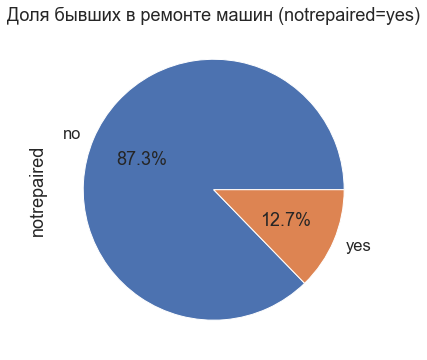

In [11]:
plt.figure(figsize=(12, 6))
df['notrepaired'].value_counts().plot.pie(autopct="%.1f%%")
plt.title('Доля бывших в ремонте машин (notrepaired=yes)');

* В 12.7% анкет авто бывали в ремонте. 

Проверим действительно ли фактор сильно влияют на цену:

In [12]:
notrepaired_table = df.groupby('notrepaired')['price'].mean()
notrepaired_table

notrepaired
no     5296.856015
yes    1915.961889
Name: price, dtype: float64

* Средняя бывавшего в ремонте авто более чем в 2 раза ниже.

Также добавим данные о пропущенных значениях:

In [13]:
df[df['notrepaired'].isna()]['price'].mean()

2626.4192455800094

In [14]:
notrepaired_table = notrepaired_table.append(pd.Series(df[df['notrepaired'].isna()]['price'].mean()).rename({0:'no_data'}))

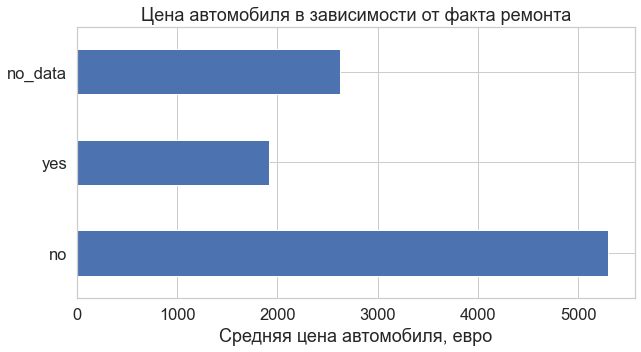

In [15]:
notrepaired_table.plot(kind='barh', figsize=(10, 5))
plt.title('Цена автомобиля в зависимости от факта ремонта')
plt.xlabel('Средняя цена автомобиля, евро');

* Средняя цена автомобиля, который <b>не был</b> в ремонте 5297 евро
* Средняя цена автомобиля, который <b>был</b> в ремонте 1916 евро
* Средняя цена автомобиля, у которого по признаку "был ли в ремонте" <b>нет данных</b> 2626 евро

Примечательно, что в объектах, где пропущено значение признака notrepaired, среднее значение целевого признака намного ближе к yes. Вероятно, авторы объявлений зачастую хотели умолчать о факте ремонта/восстановления авто. Хорошо, что в нашем приложении нельзя будет оставить поле пустым, либо "был в ремонте" либо "не был в ремонте". При этом разница в ценах очень велика для того чтобы автоматически относить всех, кто оставил поле пустым к битым (более 30%). Поэтому, на мой взгляд, здесь лучшим вариантом для обработки будет удаление пустых значений. Альтернатива - замена пустых значений на yes.

In [16]:
df = df.dropna(subset = ['notrepaired'])

Также заменим yes на 1, no на 0, а тип данных на булев:

In [17]:
df['notrepaired'] = (df['notrepaired'].replace({'yes': 1, 'no' : 0})).astype('bool')

### Обработка признака vehicletype

Cледующий по количеству пропусков признак - vehicletype. Там ~10,5% пропусков. Посмотрим как разные типы кузова влияют на цену:

In [18]:
vehicletype_table = df.groupby('vehicletype')['price'].mean().sort_values(ascending = False)
vehicletype_table

vehicletype
suv            9311.735926
convertible    7185.948534
coupe          6479.788440
bus            5723.512879
wagon          5231.071080
sedan          5009.076607
other          3854.535112
small          2937.599045
Name: price, dtype: float64

Добавим в таблицу среднюю цену по строкам, в которых отсутствует признак vehicletype_table (NaN):

In [19]:
vehicletype_table = vehicletype_table.append(pd.Series(df[df['vehicletype'].isna()]['price'].mean()).rename({0:'no_data'}))
vehicletype_table

suv            9311.735926
convertible    7185.948534
coupe          6479.788440
bus            5723.512879
wagon          5231.071080
sedan          5009.076607
other          3854.535112
small          2937.599045
no_data        2820.438560
dtype: float64

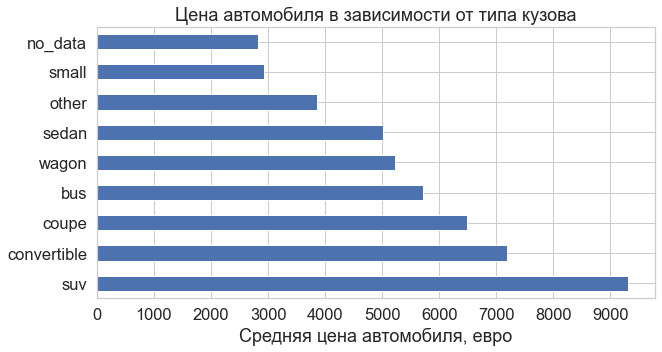

In [20]:
vehicletype_table.plot(kind='barh', figsize=(10, 5))
plt.title('Цена автомобиля в зависимости от типа кузова')
plt.xlabel('Средняя цена автомобиля, евро')
plt.xticks(np.arange(0, vehicletype_table.max(), 1000));

Цена в зависимости от кузова сильно варьируется. Это значимый фактор. При этом, интересно, что там где признак vehicletype=NaN цены в среднем почти в два раза ниже, чем в целом по датасету. Значение целевого признака в пустых vehicletype ближе всего к small, и существенно ниже, чем в остальных. Возможно это какая-то дешевая категория авто, которая не была предусмотрена для выбора на сайте объявлений (мотоциклы?). Считаю оправданным создать отдельную категорию под незаполненные поля вместо удаления данных.

In [21]:
df['vehicletype'] = df['vehicletype'].fillna('unknown')

### Обработка признака fueltype

In [22]:
df['fueltype'].isna().mean()

0.057603694771742625

Следующий признак, который нужно обработать - fueltype. В нём осталось ~5.8% пропусков.

In [23]:
df['fueltype'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Сразу добавим в таблицу среднюю цену по строкам, в которых отсутствует признак fueltype_table (NaN):

In [24]:
fueltype_table = df.groupby('fueltype')['price'].mean().sort_values(ascending = False)
fueltype_table = fueltype_table.append(pd.Series(df[df['fueltype'].isna()]['price'].mean()).rename({0:'no_data'}))
fueltype_table

hybrid      9974.911215
electric    7053.910256
gasoline    6937.340556
cng         4660.907662
lpg         4260.621174
petrol      4082.851190
other       3033.230088
no_data     2831.807405
dtype: float64

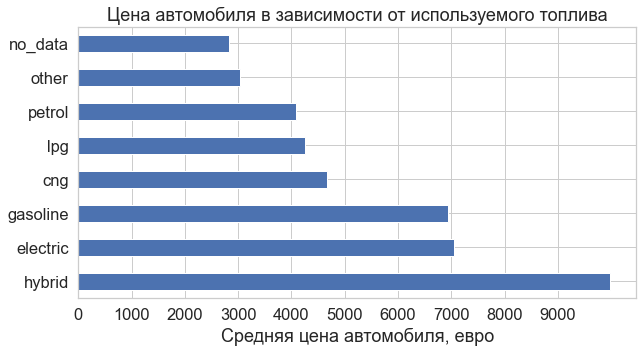

In [25]:
fueltype_table.plot(kind='barh', figsize=(10, 5))
plt.title('Цена автомобиля в зависимости от используемого топлива')
plt.xlabel('Средняя цена автомобиля, евро')
plt.xticks(np.arange(0, fueltype_table.max(), 1000));

Средний показатель целевого признака в fueltype среди пропущенных значений ниже, чем среди других типов используемого автомобилем топлива. Среди других типов показатель цены ближе всего к типу other, причем все другие категории значительно выше по показателю. На мой взгляд, чтобы избежать удаления данных, вполне можно отнести пропущенные значения к типу "другие". Это удобно как с позиции смысла категории (можно всё в "другие" относить) так и с позиции небольшой разницы (~7%) в средних значениях между категорией other и пропущенными значениями.

In [26]:
df['fueltype'] = df['fueltype'].fillna('other')

### Обработка признака model

In [27]:
df['model'].isna().mean()

0.03760800251402664

In [28]:
len(df.groupby(['model']))

249

Пропуски в model удалим, так как от модели цена будет зависеть сильнее всего, а уникальных значений в этом поле довольно много - 249шт. В то же время пропусков относительно немного - 3.76%

In [29]:
df = df.dropna(subset = ['model'])

### Обработка признака gearbox

Посмотрим на соотношение автомобилей с автоматической и механической коробками:

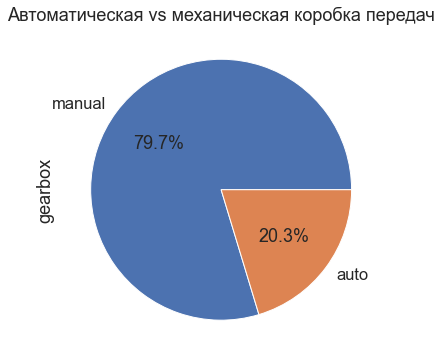

In [30]:
plt.figure(figsize=(12, 6))
df['gearbox'].value_counts().plot.pie(autopct="%.1f%%")
plt.title('Автоматическая vs механическая коробка передач');

Обработаем пропуски в gearbox:

In [31]:
df['gearbox'].isna().mean()

0.023205899618432637

Осталось всего 2.3% пропусков

In [32]:
gearbox_table = df.groupby('gearbox')['price'].mean().sort_values(ascending = False)
gearbox_table = gearbox_table.append(pd.Series(df[df['gearbox'].isna()]['price'].mean()).rename({0:'no_data'}))
gearbox_table

auto       7252.173792
manual     4366.338589
no_data    3295.668933
dtype: float64

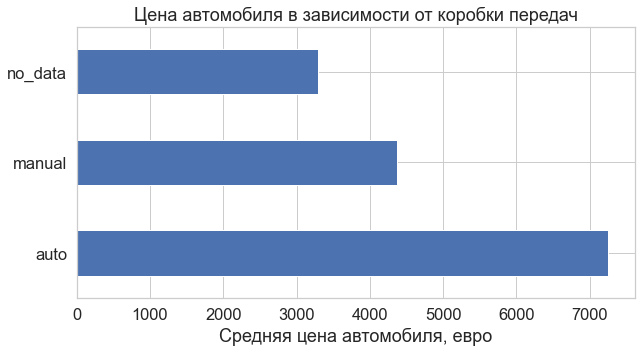

In [33]:
gearbox_table.plot(kind='barh', figsize=(10, 5))
plt.title('Цена автомобиля в зависимости от коробки передач')
plt.xlabel('Средняя цена автомобиля, евро')
plt.xticks(np.arange(0, gearbox_table.max(), 1000));

Средняя цена авто с автоматической коробкой на 66% выше, чем с механической. При этом по пропускам снова наблюдается ситуация с заниженным средним значением целевого признака (-25% от механики). Лучшим решением вижу удаление пропусков.

In [34]:
df = df.dropna(subset = ['gearbox'])

Также в gearbox есть возможность трансформировать тип данных в булев:

In [35]:
df['gearbox'] = (df['gearbox'].replace({'auto': 1, 'manual' : 0})).astype('bool')

Автоматическая коробка - это теперь "1" или "True", переименуем столбец чтобы было интуитивно понятно:

In [36]:
df = df.rename(columns = {'gearbox': 'isautogearbox'})

### Измнение типов данных, обработка признаков postalcode и numberofpictures

Проверим остались ли пропуски и перейдем к типам данных:

In [37]:
df.isna().sum()

datecrawled          0
price                0
vehicletype          0
registrationyear     0
isautogearbox        0
power                0
model                0
kilometer            0
registrationmonth    0
fueltype             0
brand                0
notrepaired          0
datecreated          0
numberofpictures     0
postalcode           0
lastseen             0
dtype: int64

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266235 entries, 3 to 354367
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        266235 non-null  object
 1   price              266235 non-null  int64 
 2   vehicletype        266235 non-null  object
 3   registrationyear   266235 non-null  int64 
 4   isautogearbox      266235 non-null  bool  
 5   power              266235 non-null  int64 
 6   model              266235 non-null  object
 7   kilometer          266235 non-null  int64 
 8   registrationmonth  266235 non-null  int64 
 9   fueltype           266235 non-null  object
 10  brand              266235 non-null  object
 11  notrepaired        266235 non-null  bool  
 12  datecreated        266235 non-null  object
 13  numberofpictures   266235 non-null  int64 
 14  postalcode         266235 non-null  int64 
 15  lastseen           266235 non-null  object
dtypes: bool(2), int64(7)

Прежде чем снизить разрядность целочисленного типа, посмотрим на разброс значений в признаках этого типа. Удобнее всего сделать это при помощи метода describe:

In [39]:
df.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,266235.000000,266235.000000,266235.000000,266235.000000,266235.000000,266235.0,266235.000000
mean,4952.740823,2003.484583,118.281304,127741.731929,6.083870,0.0,51177.291461
std,4674.546085,23.131105,160.519552,36957.895885,3.533278,0.0,25850.990825
min,0.000000,1600.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1350.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30827.000000
50%,3300.000000,2004.000000,110.000000,150000.000000,6.000000,0.0,50259.000000
75%,7200.000000,2008.000000,150.000000,150000.000000,9.000000,0.0,72124.000000
max,20000.000000,9000.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Отмечу, что заметна предобработка данных: максимальная цена ограничена 20000 евро, пробег 150 тыс. километров. При этом ограничение по пробегу выглядит лишним, максимальное значение совпадает даже с медианой, из чего следует, распределение значений на графике будет сильно скошено влево, хотя могло бы быть близким к нормальному - признак вполне подходящий. Дополнительно я бы очистил выбросы в registrationyear и, возможно, в power. Сделаю это после изменения типов данных. Также можно удалить numberofpictures потому что признак содержит только нули. Из postalcode хоть и не связан с целевым признаком очевидным образом, но его можно использовать как признак географии авто, для этого оставим только первую цифру чтобы уменьшить количество категорий.

In [40]:
df = df.drop('numberofpictures', axis = 1)

Максимальное значение в int32 - 2,147,483,647. Максимальное значение в нашем датасете - 150,000. Изменим типы:

In [41]:
df['price'] = df['price'].astype('int32')
df['registrationyear'] = df['registrationyear'].astype('int32')
df['power'] = df['power'].astype('int32')
df['kilometer'] = df['kilometer'].astype('int32')
df['registrationmonth'] = df['registrationmonth'].astype('int32')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266235 entries, 3 to 354367
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        266235 non-null  object
 1   price              266235 non-null  int32 
 2   vehicletype        266235 non-null  object
 3   registrationyear   266235 non-null  int32 
 4   isautogearbox      266235 non-null  bool  
 5   power              266235 non-null  int32 
 6   model              266235 non-null  object
 7   kilometer          266235 non-null  int32 
 8   registrationmonth  266235 non-null  int32 
 9   fueltype           266235 non-null  object
 10  brand              266235 non-null  object
 11  notrepaired        266235 non-null  bool  
 12  datecreated        266235 non-null  object
 13  postalcode         266235 non-null  int64 
 14  lastseen           266235 non-null  object
dtypes: bool(2), int32(5), int64(1), object(7)
memory usage: 23.9+ MB


## Создание новых признаков

Чтобы добиться более высокого качества при моделировании цен, создадим следующие признаки на основе существующих:
* Признак географии - первая цифра от postalcode
* Количество времени, которое объявление было размещено на сайте - получим в результате преобразования и вычета разницы между признаками datecreated и lastseen
* Признак принадлежности автомобиля к ретрокарам
<br> Идея в следующем: 
<br> 1) Признак географии может помочь определить место жительства владельница, от региона может зависеть цена продажи автомобиля, особенно если речь идёт о разных станах ЕС
<br> 2) Количество времени, которое объявление "провисело" на сайте может говорить о переоценности тех авто, объявления на которые не закрываются в течение длительного времени. Ожидаю увидеть слабоположительную корреляцию нового признака и цены.
<br> 3) Признак принадлежности автомобиля к ретрокарам - ценообразование на старые автомобили может существенно отличаться от интуитивно понятного. Если не создать признак, то увеличение возраста автомобиля будет однозначно означать ухудшение цены за которую можно продать авто, хотя в реальности это не всегда так

Создадим признак времени жизни объявления. Изменим тип данных в datecreated и lastseen на дейттайм:

In [43]:
df['datecreated'] = pd.to_datetime(df['datecreated'])
df['lastseen'] = pd.to_datetime(df['lastseen'])

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266235 entries, 3 to 354367
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        266235 non-null  object        
 1   price              266235 non-null  int32         
 2   vehicletype        266235 non-null  object        
 3   registrationyear   266235 non-null  int32         
 4   isautogearbox      266235 non-null  bool          
 5   power              266235 non-null  int32         
 6   model              266235 non-null  object        
 7   kilometer          266235 non-null  int32         
 8   registrationmonth  266235 non-null  int32         
 9   fueltype           266235 non-null  object        
 10  brand              266235 non-null  object        
 11  notrepaired        266235 non-null  bool          
 12  datecreated        266235 non-null  datetime64[ns]
 13  postalcode         266235 non-null  int64   

Создадим новый признак - разница между созданием объявления и последним просмотром:

In [45]:
df['lifetime'] = df['lastseen'] - df['datecreated']

In [46]:
df['lifetime'].describe()

count                     266235
mean      9 days 10:56:35.180152
std       8 days 13:56:27.333313
min              0 days 00:25:36
25%       2 days 14:56:37.500000
50%              6 days 14:56:03
75%      14 days 05:15:48.500000
max            384 days 03:45:01
Name: lifetime, dtype: object

* В среднем, срок жизни объявления на сайте чуть меньше 10 дней, при этом медиана 6.5 дней, что говорит о длинном хвосте распределения (распределение Пуассона). На мой взгляд, при очистке выбросов, лучше вообще избавиться от объявлений, которые висят на сайте аномально долго. Остальные же модель будет учитывать при обучении определять цену.

Извлечем дни из таймдельта формата:

In [47]:
df['lifetime'] = df['lifetime'].dt.days

In [48]:
df['lifetime'].describe()

count    266235.000000
mean          8.941326
std           8.614969
min           0.000000
25%           2.000000
50%           6.000000
75%          14.000000
max         384.000000
Name: lifetime, dtype: float64

In [49]:
df['lifetime'] = df['lifetime'].astype('int32')

Удалим теперь уже ненужные признаки:

In [50]:
df = df.drop(columns=['datecreated', 'lastseen'], axis = 1)

Создадим признак географии. Проверим какими бывают коды:

In [51]:
df['postalcode'].describe()

count    266235.000000
mean      51177.291461
std       25850.990825
min        1067.000000
25%       30827.000000
50%       50259.000000
75%       72124.000000
max       99998.000000
Name: postalcode, dtype: float64

Почтовый код, как правило, пятизначный, но есть и четырехзначные значения. Их заменим на нули. В пятизначных кодах оставим только первую цифру чтобы уменьшить количество классов. Затем оставим только первую цифру чтобы уменьшить количество классов.

In [52]:
# Вычитаю 10000 (минимальное пятизначное значение) чтобы вывести все четырехзначные числа в отрицательную шкалу:
df['postalcode'] = df['postalcode'] - 10000
# Обнуляю все отрицательные числа:
df['postalcode'][df['postalcode'] < 0] = 0
# Возвращаю 10000 всем необнуленным объектам:
df['postalcode'][df['postalcode'] > 0] = df['postalcode'][df['postalcode'] > 0] + 10000
# Оставляю только первую цифру путем конвертации в строковое значение и обратно:
df['postalcode'] = df.postalcode.astype(str).str[0].astype('int8')

Посмотрим на получившиеся признаки:

In [53]:
df[['lifetime', 'postalcode']].head(10)

,lifetime,postalcode
3,0,9
4,6,6
5,2,3
6,4,6
7,4,1
10,11,9
11,0,5
13,2,9
14,16,0
17,17,6


Добавим признак принадлежности автомобиля к ретрокарам. Краткий ресерч данного вопроса в google позволил понять, что в разных странах разное определение понятия ретрокара. Где-то есть чёткая граница и организация, которая официально признаёт автомобиль историческим при определенных условиях, а где-то нет. В качестве компромисса добавим 2 признака:
<br> 1) Принадлежность к классическому авто - автомобилем возрастом от 20 до 40 лет. В некоторых странах действует особый режим налогооблажения для таких авто и другие условия страховки.
<br> 2) Исторический авто - автомобиль старше 40 лет

Посмотрим какая у нас актуальная дата сбора информация из датасета (этот признак заполняется автоматически, в то время как в registrationyear могут быть выбросы в большую сторону из-за заполнения поля пользователем):

In [54]:
df['datecrawled'].max()

'2016-04-07 14:36:58'

Создадим сами признаки, где 1 - принадлежность к данному классу:

In [55]:
df['isretro'] = df['registrationyear'][df['registrationyear'] < 1977]
df['isretro'] = df['isretro'].fillna(0)
df['isretro'][df['isretro'] > 0] = 1

df['isclassic'] = df['registrationyear'][(df['registrationyear'] < 1997) & (df['registrationyear'] >= 1977)]
df['isclassic'] = df['isclassic'].fillna(0)
df['isclassic'][df['isclassic'] > 0] = 1

Изменим типы данных у новых признаков:

In [56]:
df['isretro'] = df['isretro'].astype('bool')
df['isclassic'] = df['isclassic'].astype('bool')

In [57]:
df.head()

,datecrawled,price,vehicletype,registrationyear,isautogearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,postalcode,lifetime,isretro,isclassic
3,2016-03-17 16:54:04,1500,small,2001,False,75,golf,150000,6,petrol,volkswagen,False,9,0,False,False
4,2016-03-31 17:25:20,3600,small,2008,False,69,fabia,90000,7,gasoline,skoda,False,6,6,False,False
5,2016-04-04 17:36:23,650,sedan,1995,False,102,3er,150000,10,petrol,bmw,True,3,2,False,True
6,2016-04-01 20:48:51,2200,convertible,2004,False,109,2_reihe,150000,8,petrol,peugeot,False,6,4,False,False
7,2016-03-21 18:54:38,0,sedan,1980,False,50,other,40000,7,petrol,volkswagen,False,1,4,False,True


## Работа с выбросами, удаление лишних признаков

In [58]:
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear',
       'isautogearbox', 'power', 'model', 'kilometer', 'registrationmonth',
       'fueltype', 'brand', 'notrepaired', 'postalcode', 'lifetime', 'isretro',
       'isclassic'],
      dtype='object')

Посмотрим на распределения числовых признаков:

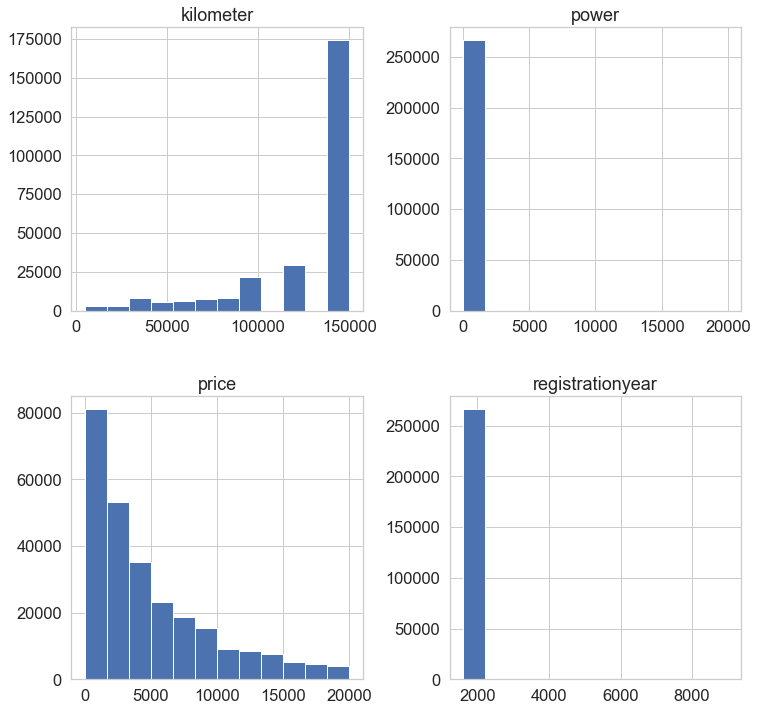

In [59]:
df[['price', 'registrationyear', 'power', 'kilometer']].hist(figsize=(12, 12), bins=12);

* В kilometr виден большой перекос значений равных 150к (максимум), что уже было выявлено методом describe
* В power и registrationyear графики искажены из-за наличия выбросов
* В целевом признаке (price) распределение скошено влево, вероятно присутствует много нулевых значений

Прежде чем перейти к очистке выбросов посмотрим на распределения через scatterplot. Также добавим признак месяца регистрации, возможно его стоит удалить:

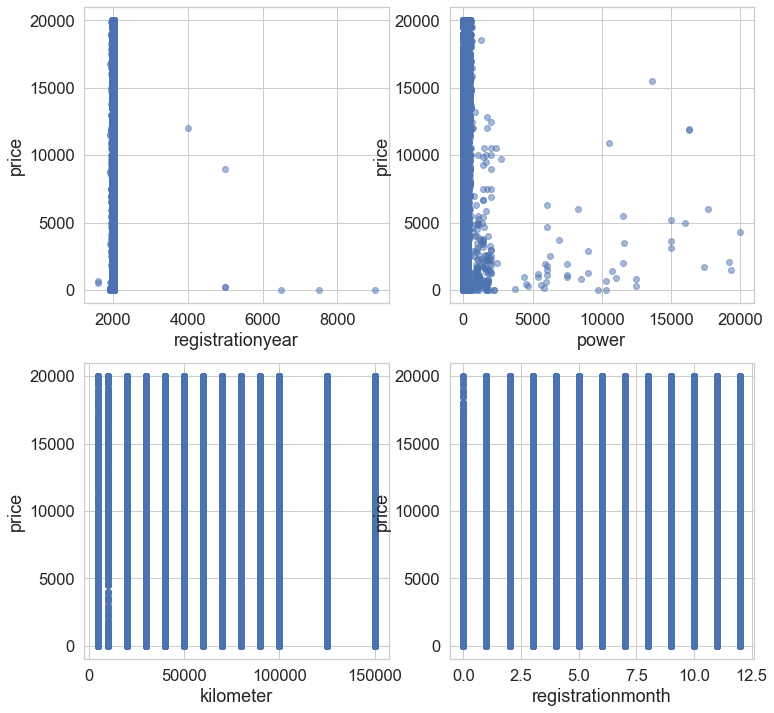

In [60]:
fig, ax = plt.subplots(2,2, figsize = (12, 12))

for i in range(2):
    for j in range(2):
        ax[i,j].set_ylabel('price')

ax[0,0].scatter(x= df['registrationyear'], y=df['price'], alpha=0.5)
ax[0,1].scatter(x= df['power'], y=df['price'], alpha=0.5)
ax[1,0].scatter(x= df['kilometer'], y=df['price'], alpha=0.5)
ax[1,1].scatter(x= df['registrationmonth'], y=df['price'], alpha=0.5)

ax[0,0].set_xlabel('registrationyear')
ax[0,1].set_xlabel('power')
ax[1,0].set_xlabel('kilometer')
ax[1,1].set_xlabel('registrationmonth');

* Признак километрожа принимает только определенные, "ровные" значения. Учитывая также перекос значений, равных 150000, можно попробовать подать в модель километраж в качестве категориального признака.
* registrationyear и power стоит повторно оценить после очистки выбросов, причем лучше всего подойдет экспертный метод.
* Месяц регистрации распределен на графике одинаково по месяцам.


Проверим значения registrationmonth: 

In [61]:
df.groupby('registrationmonth')['price'].agg({'count', 'mean'})

,count,mean
registrationmonth,,
0,12143,2162.089599
1,18533,5065.133492
2,17249,4942.948693
3,28169,4938.047002
4,23474,5137.487561
5,23157,5037.082783
6,25024,5089.028573
7,21619,5106.690457
8,18083,5016.756346


Имеется довольно много нулевых (несуществующих/не указанных) месяцев с сильно заниженой ценой. Такие данные могут создавать лишний шум, удалим признак:

In [62]:
df = df.drop(columns=['registrationmonth'], axis = 1)

Удалим выбросы в годе выпуска автомобиля. Нижней границей будет выпуск первого серийного автомобиля (1915 год), верхней - год сбора данных из базы (2016 год):

In [63]:
df = df.query('registrationyear > 1914 and registrationyear < 2017')

Посмотрим на распределениепризнака power при помощи boxplot:

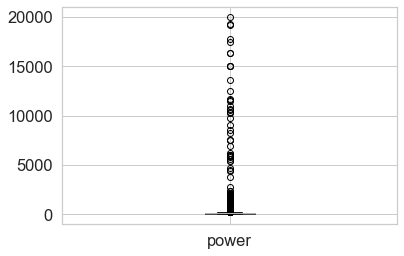

In [64]:
df[['power']].boxplot();

На боксплоте он графически состоит целиком из огромных выбросов. При том, больше 1000 л.с. могут иметь только суперкары. В нашем случае это вероятнее всего ошибки пользователей, например когда вместо трех знаков (например 103) пользователь указывает 4 (например 1003). Однако в данном случае поставим границу ниже для отсечки, т.к. автомобили с ценой до 20 тысяч евро даже близко не будут суперкарами, оправданной границей будет 600 л.с. и то из-за присутствия в датасете автобусов, самые мощные из которых могут иметь двигатели до 510 л.с. https://www.volvobuses.ru/ru-ru/our-offering/chassis/volvo-b290r.html.

In [65]:
df[['brand', 'model', 'power']].query('power > 600').head(10)

,brand,model,power
1816,toyota,corolla,1398
4060,mitsubishi,colt,953
6296,chevrolet,matiz,603
6637,opel,corsa,603
9664,opel,zafira,1779
9875,ford,focus,1753
11039,fiat,other,10317
12740,ford,ka,952
15433,ford,escort,999
19078,seat,ibiza,1111


In [66]:
df.query('power > 600')['brand'].unique()

array(['toyota', 'mitsubishi', 'chevrolet', 'opel', 'ford', 'fiat',
       'seat', 'bmw', 'nissan', 'mercedes_benz', 'citroen', 'skoda',
       'volkswagen', 'volvo', 'kia', 'smart', 'mazda', 'renault', 'audi',
       'alfa_romeo', 'mini', 'honda', 'chrysler', 'suzuki', 'hyundai',
       'lancia'], dtype=object)

Суперкаров не обнаружено. Всё-таки в большинстве случаев это ошибки пользователей.

In [67]:
df = df.query('power < 600')

Посмотрим как изменились распределения:

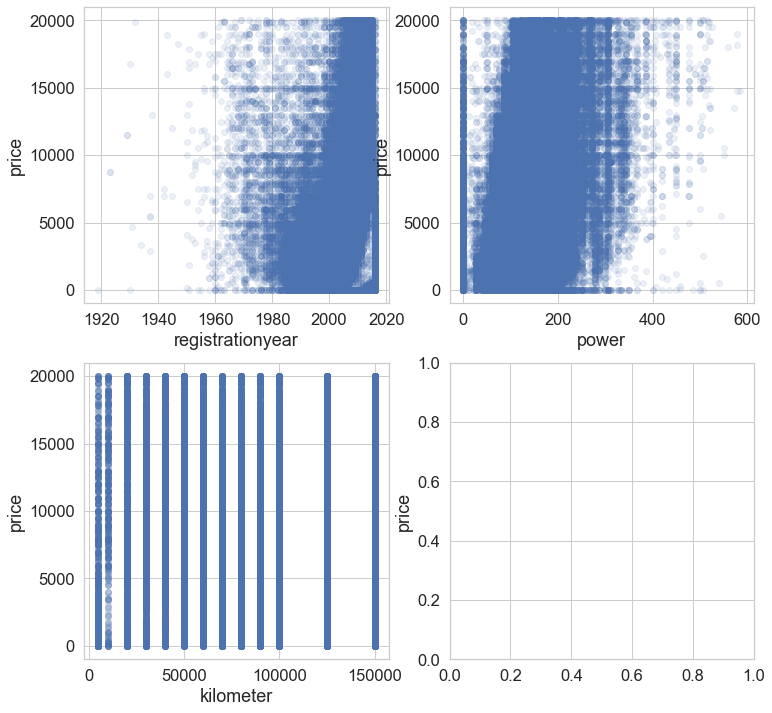

In [68]:
fig, ax = plt.subplots(2,2, figsize = (12, 12))

for i in range(2):
    for j in range(2):
        ax[i,j].set_ylabel('price')

ax[0,0].scatter(x= df['registrationyear'], y=df['price'], alpha=0.1)
ax[0,1].scatter(x= df['power'], y=df['price'], alpha=0.1)
ax[1,0].scatter(x= df['kilometer'], y=df['price'], alpha=0.1)

ax[0,0].set_xlabel('registrationyear')
ax[0,1].set_xlabel('power')
ax[1,0].set_xlabel('kilometer');

* В power есть много нулевых значений, необходимо установить и нижнюю границу для отсечки
* Также есть много объектов с нулевым значением целевого признака
* У обоих признаков зависимость нелинейная, рост цены у более новых автомобилей прослеживается слабо. Рост цены автомобиля при увеличении power прослеживается по scatterplot чуть лучше

Посмотрим на получившейся боксплот по признаку power:

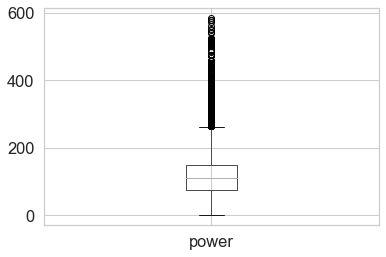

In [69]:
df[['power']].boxplot();

* Всё ещё очень много выбросов на графике. Значения выше ~240 л.с. лежат за пределами "усов". Однако этот подход не очень хорошо работает, если распределение не нормальное. В силу специфики бизнес-задачи, данный метод обнаружения выбросов может посчитать посчитать ими показатели мощных спортивных машин или автобусов. Поэтому, на мой взгляд, при решении этой бизнес-задачи лучше очищать выбросы опираясь на экспертные знания, тем более мы разрабатываем приложение с ограничениями.

Важно установить нижнюю границу по признаку power. Чтобы сэкономить время, удалим 1% наименьших значений, однако сделаем это после очистки нулей, которых у нас довольно много: 4.7% от всего датасета.

In [70]:
len(df.query('power==0')) / len(df)

0.04760252317278181

In [71]:
df = df.query('power > 0')

In [72]:
df['power'].quantile(0.01)

45.0

In [73]:
df = df.query('power > 44')

* Нижней границей будут авто с двигателем слабее 44 л.с.

В признаке price тоже много нулей. Нулевые значения целевого признака нам точно ничем не помогут. Также, удалим 1% самых дешевых авто - так проще всего отсечь мошеннические объявления и ошибочно выставленные цены.

In [74]:
len(df.query('price==0')) / len(df)

0.014335427821650652

In [75]:
df = df.query('price > 0')

In [76]:
df['price'].quantile(0.01)

200.0

* Границей отсечения будут авто дешевле 200 евро.

In [77]:
df = df.query('price > 200')

Далее очистим датасет от непопулярных моделей. Это должно затронуть менее 1% пользователей.

Найдем 50 самых непопулярных моделей:

In [78]:
df.groupby('model')['model'].count().sort_values(ascending = True).head(50)

model
rangerover             1
601                    1
range_rover_evoque     2
elefantino             2
samara                 3
serie_3                3
i3                     4
serie_2                5
kalina                 5
gl                    10
kappa                 10
move                  11
amarok                11
200                   11
materia               12
q3                    13
charade               14
musa                  17
9000                  20
delta                 24
b_max                 25
terios                25
145                   27
lodgy                 29
lybra                 34
croma                 34
v60                   38
911                   41
nubira                42
lanos                 48
range_rover_sport     49
defender              51
glk                   53
cx_reihe              55
crossfire             55
90                    55
range_rover           61
discovery             66
r19                   68
kalos              

Удалим 50 самых непопулярных моделей. Количество объявлений по каждой из этих моделей не превышает 91 шт. Это затронет очень мало объявлений, посчитаем сколько:

In [79]:
df.groupby('model')['model'].count().sort_values(ascending = True).head(50).cumsum()[49] / len(df)

0.007999029406473691

* Отсутствие подсчета цен по самым непопулярным моделям затронет 0.8% пользователей

Пользователю с такой моделью вместо оценки должно выводиться сообщение "Недостаточно данных для расчёта стоимости вашего авто". На мой взгляд это очень правильно и можно было бы использовать даже в базовом решении, т.к. от модели цена зависит сильнее всего и именно в таких случаях даже если бы оценка выводилась, то она была бы наиболее неточной.

Удалим модели, предварительно создав список самых непопулярных моделей:

In [80]:
unpopular_models = df.groupby('model')['model'].count().sort_values(ascending = True).head(50).index.to_list()
df = df[~df['model'].isin(unpopular_models)]

Посмотрим как теперь выглядит датасет:

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237117 entries, 3 to 354367
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   datecrawled       237117 non-null  object
 1   price             237117 non-null  int32 
 2   vehicletype       237117 non-null  object
 3   registrationyear  237117 non-null  int32 
 4   isautogearbox     237117 non-null  bool  
 5   power             237117 non-null  int32 
 6   model             237117 non-null  object
 7   kilometer         237117 non-null  int32 
 8   fueltype          237117 non-null  object
 9   brand             237117 non-null  object
 10  notrepaired       237117 non-null  bool  
 11  postalcode        237117 non-null  int8  
 12  lifetime          237117 non-null  int32 
 13  isretro           237117 non-null  bool  
 14  isclassic         237117 non-null  bool  
dtypes: bool(4), int32(5), int8(1), object(5)
memory usage: 16.5+ MB


In [82]:
df = df.query('lifetime < 32')

Также удалим теперь уже ненужный признак datecrawled:

In [83]:
df = df.drop('datecrawled', axis = 1)

Посмотрим на получившееся распределение:

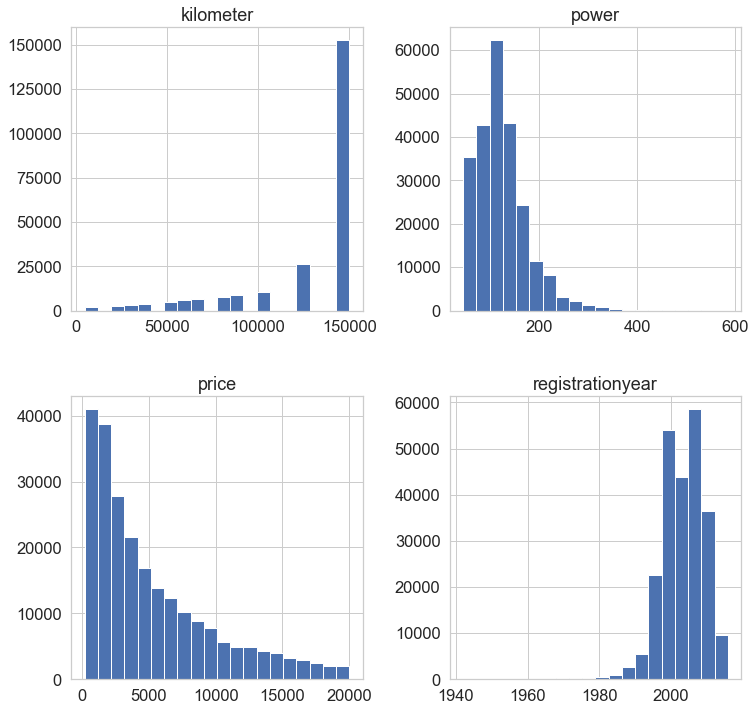

In [84]:
df[['price', 'registrationyear', 'power', 'kilometer']].hist(figsize=(12, 12), bins=20);

* Графики по power и registrationyear теперь намного информативнее. Power остался скошенным влево из-за опасений убрать спорткары и автобусы, а registrationyear скошен вправо из-за ретрокаров и классики, для определения которых созданы специальные признаки.

Посмотрим на корреляционную матрицу по числовым признакам:

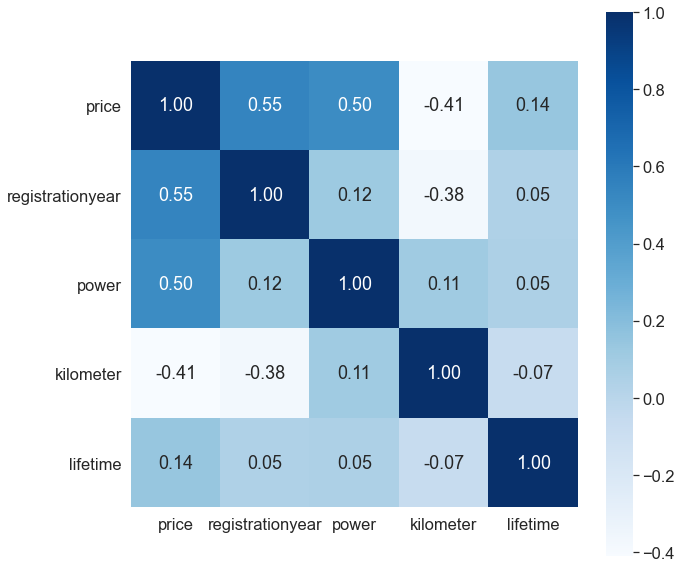

In [85]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df[['price', 'registrationyear', 'power', 'kilometer', 'lifetime']].corr(),\
            annot = True, square=True, cmap='Blues', fmt='.2f');

* Матрица в основном отражает интуитивно понятные факты: чем больше год выпуска, тем выше цена; чем больше мощность двигателя, тем выше цена, чем больше пробег, тем ниже цена.
* Здорово, что мы получили слабоположительную корреляцию между новым признаком lifetime и целевым.
* Также отражена интуитивно понятная корреляция между годом выпуска и километражом: чем меньше год выпуска, тем больше километраж.

In [86]:
df.head()

,price,vehicletype,registrationyear,isautogearbox,power,model,kilometer,fueltype,brand,notrepaired,postalcode,lifetime,isretro,isclassic
3,1500,small,2001,False,75,golf,150000,petrol,volkswagen,False,9,0,False,False
4,3600,small,2008,False,69,fabia,90000,gasoline,skoda,False,6,6,False,False
5,650,sedan,1995,False,102,3er,150000,petrol,bmw,True,3,2,False,True
6,2200,convertible,2004,False,109,2_reihe,150000,petrol,peugeot,False,6,4,False,False
10,2000,sedan,2004,False,105,3_reihe,150000,petrol,mazda,False,9,11,False,False


## Обучение моделей

При решении этой задачи хорошо показали себя модели градиентного бустинга, но обучим также и случайный лес чтобы воспользоваться стекингом. Линейные модели здесь показывают плохой результат из-за сложности распределения данных.

### Случайный лес

Для того чтобы обучить лес нужно преобразовать признаки с типом object каким-либо кодировщиком. Воспользуемся встроенным в pandas методом get_dummies, он создаёт на каждую категорию отдельный признак булева типа. Большое количество признаков замедлит скорость обучения леса, но качество должно быть выше.

In [87]:
data_forest = pd.get_dummies(data=df, drop_first=True)

In [88]:
data_forest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235535 entries, 3 to 354367
Columns: 260 entries, price to brand_volvo
dtypes: bool(4), int32(5), int8(1), uint8(250)
memory usage: 63.6 MB


Зафиксируем псевдослучайность:

In [89]:
random_state = 0

In [90]:
data_forest_train, data_forest_test = train_test_split(data_forest, test_size=0.25, random_state=random_state)

In [91]:
display(len(data_forest_train)/len(data_forest))
display(len(data_forest_test)/len(data_forest))

0.7499989385866219

0.2500010614133781

Выделим целевой признак:

In [92]:
X_train_forest = data_forest_train.drop('price', axis=1)
y_train_forest = data_forest_train['price']

X_test_forest = data_forest_test.drop('price', axis=1)
y_test_forest = data_forest_test['price']

Масштабируем данные:

In [93]:
numeric = ['registrationyear', 'power', 'kilometer', 'lifetime']

In [94]:
scaler = StandardScaler()

In [95]:
scaler.fit(X_train_forest[numeric])

StandardScaler()

In [96]:
X_train_forest[numeric] = scaler.transform(X_train_forest[numeric])
X_test_forest[numeric] = scaler.transform(X_test_forest[numeric])

In [97]:
X_train_forest.head()

,registrationyear,isautogearbox,power,kilometer,notrepaired,postalcode,lifetime,isretro,isclassic,vehicletype_convertible,...,brand_saab,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
115246,-0.048335,False,0.014516,0.612575,False,5,1.831934,False,False,0,...,0,0,0,0,0,0,0,0,1,0
175851,-0.214001,False,-1.114485,0.612575,False,7,-0.590798,False,False,0,...,0,0,0,0,0,0,0,0,1,0
283475,0.945661,False,0.691917,0.612575,False,6,0.862841,False,False,0,...,0,0,0,0,0,0,0,0,1,0
25803,-0.545333,False,0.880084,0.612575,False,6,-0.348525,False,False,0,...,0,0,0,0,0,0,0,0,0,0
37474,1.442660,False,1.444584,0.612575,True,8,-0.348525,False,False,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
X_test_forest.head()

,registrationyear,isautogearbox,power,kilometer,notrepaired,postalcode,lifetime,isretro,isclassic,vehicletype_convertible,...,brand_saab,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
221441,0.614329,False,-0.343001,0.612575,False,3,0.257158,False,False,0,...,0,0,0,0,0,0,0,0,1,0
282422,0.282997,True,0.033333,-1.562365,False,6,-0.348525,False,False,0,...,0,0,0,0,0,0,0,0,0,0
194798,0.779995,False,-0.888685,-2.377968,False,2,0.741704,False,False,0,...,0,0,0,0,0,0,0,0,0,0
106536,0.779995,False,-1.189752,-1.562365,False,9,-0.469662,False,False,0,...,0,0,0,0,0,0,0,0,1,0
318118,0.282997,True,-0.136018,0.612575,False,1,-0.590798,False,False,0,...,0,0,0,0,0,0,0,0,1,0


В итоге сет признаков получился довольно простым: год регистрации, коробка передач, мощность, пробег, факт ремонта и дополнительные признаки. Числовые признаки стандартизированы через StandardScaler. Ещё 249 признаков - по сути 3 признака, закодированные через get_dummy кодировщик.

Ключевой метрикой оценки моделей согласно ТЗ будет RMSE. Сразу проверим константную модель:

In [99]:
constant_model_predicted = pd.Series(y_train_forest.mean(), index=X_test_forest.index)

In [100]:
mean_squared_error(y_test_forest, constant_model_predicted)**0.5

4678.796531645139

RMSE константной модели 4678. Обучим лес.

Зададим параметры для обучения:

In [101]:
params_forest = {
            'n_estimators' : [50, 75, 100, 125, 150],
            'max_depth':[25, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120],
            'max_features': ['log2', 'auto','sqrt'],
            'min_samples_leaf': [1, 3, 5, 8, 10, 12],
            'min_samples_split': [2, 4, 6, 10, 14, 16, 20],
              }

Подберем параметры при помощи RandomizedSearchCV:

Подобрались следующие гиперпараметры:

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 60}

Лучший RMSE леса с указанными параметрами на кросс-валидации:

In [102]:
RMSE_FOREST_VALID = np.abs(-2384878.782809289**0.5)
RMSE_FOREST_VALID

1544.3052751348384

* RMSE леса на кросс-валидациии 1544 (в базовом варианте решения задачи было 1578)

Обучим модель и проверим на тестовой выборке:

In [103]:
%%time
model_forest = RandomForestRegressor(max_depth=60, random_state=0)
model_forest.fit(X_train_forest, y_train_forest)

Wall time: 5min 40s


RandomForestRegressor(max_depth=60, random_state=0)

In [104]:
FIT_TIME_FOREST = 5*60+45

In [105]:
%%time
predicted_forest = model_forest.predict(X_test_forest)

Wall time: 2.97 s


In [106]:
PREDICT_TIME_FOREST = 2.97

In [107]:
RMSE_FOREST_TEST = mean_squared_error(y_test_forest, predicted_forest)**0.5

* RMSE леса на тестовой выборке составил  1512

### Catboost

Для catboost не рекомендуется использовать one hot encoding. В нашем случае для кодировки использовался встроенный в pandas метод get_dummies, который является аналогом one hot encoding. Поэтому нужно изменить предобработку. Вернемся к датасету df:

In [108]:
df.head()

,price,vehicletype,registrationyear,isautogearbox,power,model,kilometer,fueltype,brand,notrepaired,postalcode,lifetime,isretro,isclassic
3,1500,small,2001,False,75,golf,150000,petrol,volkswagen,False,9,0,False,False
4,3600,small,2008,False,69,fabia,90000,gasoline,skoda,False,6,6,False,False
5,650,sedan,1995,False,102,3er,150000,petrol,bmw,True,3,2,False,True
6,2200,convertible,2004,False,109,2_reihe,150000,petrol,peugeot,False,6,4,False,False
10,2000,sedan,2004,False,105,3_reihe,150000,petrol,mazda,False,9,11,False,False


Разделим выборку на обучающую и тестовую:

In [109]:
catboost_train, catboost_test = train_test_split(df, test_size=0.25, random_state=random_state)
print('В Обучающей выборке данных, %: ', len(catboost_train)/len(df)*100)
print('В тестовой выборке данных, %: ', len(catboost_test)/len(df)*100)

В Обучающей выборке данных, %:  74.99989385866219
В тестовой выборке данных, %:  25.00010614133781


Выделим целевой признак:

In [110]:
X_train_catboost = catboost_train.drop('price', axis=1)
y_train_catboost = catboost_train['price']

X_test_catboost = catboost_test.drop('price', axis=1)
y_test_catboost = catboost_test['price']

<i> Масштабирования для catboost не требуется

Создадим список категориальных признаков чтобы передать их в Catboost:

In [111]:
categorical_features = ['vehicletype', 'model', 'brand', 'fueltype']

<i> опытным путем выяснили, что kilometer всё-таки не смысла подавать как категориальный признак, конечный результат выходит чуть хуже

Запускаем catboost и подбираем гиперпараметры:

<a href="https://imgur.com/tjkmEX3"><img src="https://i.imgur.com/tjkmEX3.png" title="source: imgur.com" /></a>

* Лучший RMSE Catboost на кросс-валидации: 1467 (в базовом варианте решения задачи лучший RMSE - 1539)

In [112]:
RMSE_CATBOOST_VALID = 1467

Лучшие параметры для catboost:

{'depth': 12, 'l2_leaf_reg': 5, 'learning_rate': 0.1}

Обучим модель с подобранными параметрами:

In [113]:
%%time
model_catboost = CatBoostRegressor(eval_metric='RMSE', iterations=1000,
                                  cat_features = categorical_features,
                 depth=12, l2_leaf_reg=5, learning_rate=0.1, random_state=random_state, verbose=100)
model_catboost.fit(X_train_catboost, y_train_catboost)

0:	learn: 4337.3518148	total: 390ms	remaining: 6m 29s
100:	learn: 1448.0547768	total: 20.6s	remaining: 3m 3s
200:	learn: 1355.1721328	total: 40.4s	remaining: 2m 40s
300:	learn: 1289.7405963	total: 1m	remaining: 2m 21s
400:	learn: 1242.1456734	total: 1m 21s	remaining: 2m 2s
500:	learn: 1199.3865455	total: 1m 43s	remaining: 1m 42s
600:	learn: 1166.1699803	total: 2m 4s	remaining: 1m 22s
700:	learn: 1137.7025207	total: 2m 26s	remaining: 1m 2s
800:	learn: 1112.8520287	total: 2m 48s	remaining: 41.9s
900:	learn: 1087.3595579	total: 3m 11s	remaining: 21s
999:	learn: 1063.6936665	total: 3m 34s	remaining: 0us
Wall time: 3min 36s


In [114]:
FIT_TIME_CATBOOST = 3*60+32

Проверим обученную модель на тестовой выборке:

In [115]:
%%time
predicted_catboost = model_catboost.predict(X_test_catboost)

Wall time: 396 ms


In [116]:
PREDICT_TIME_CATBOOST = 0.408

Найдем RMSE Catboost на тестовой выборке:

In [117]:
RMSE_CATBOOST_TEST = mean_squared_error(y_test_catboost, predicted_catboost)**0.5
RMSE_CATBOOST_TEST

1447.7762940156592

* Лучший RMSE Catboost на тесте 1447

Построим график feature importances:

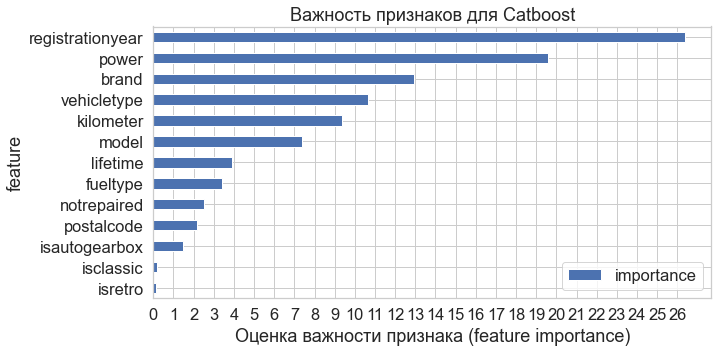

In [118]:
fi = pd.DataFrame(data ={'feature': X_train_catboost.columns, 'importance': model_catboost.feature_importances_})
fi.sort_values('importance').plot(kind='barh', x = 'feature', figsize=(10, 5))
plt.title('Важность признаков для Catboost')
plt.xlabel('Оценка важности признака (feature importance)')
plt.xticks(np.arange(0, fi['importance'].max(), 1))
plt.legend(loc="lower right");

* Самыми важным признаками модель посчитала год регистрации, мошность и брэнд.
* Дополнительно созданные признаки имеют невысокую важность за исключением lifetime.

### LightGBM

Для LightGBM нужна немного другая обработка. Он понимает категориальные признаки, но если они типа int. Воспользуемся OrdinalEncoder чтобы преобразовать датасет.

In [119]:
data_lgb = df.copy()

In [120]:
enc = OrdinalEncoder()
enc.fit(data_lgb[["vehicletype","model", "fueltype", "brand"]])

OrdinalEncoder()

In [121]:
data_lgb[["vehicletype","model", "fueltype", "brand"]] = enc.transform(data_lgb[["vehicletype","model", "fueltype", "brand"]])

In [122]:
data_lgb.head()

,price,vehicletype,registrationyear,isautogearbox,power,model,kilometer,fueltype,brand,notrepaired,postalcode,lifetime,isretro,isclassic
3,1500,5.0,2001,False,75,94.0,150000,6.0,37.0,False,9,0,False,False
4,3600,5.0,2008,False,69,82.0,90000,2.0,31.0,False,6,6,False,False
5,650,4.0,1995,False,102,9.0,150000,6.0,2.0,True,3,2,False,True
6,2200,1.0,2004,False,109,6.0,150000,6.0,25.0,False,6,4,False,False
10,2000,4.0,2004,False,105,8.0,150000,6.0,19.0,False,9,11,False,False


Разделим датасет на обучающую и тестовую выборки:

In [123]:
data_train_lgb, data_test_lgb = train_test_split(data_lgb, test_size=0.25, random_state=random_state)
print('В Обучающей выборке данных, %: ', len(data_train_lgb)/len(data_lgb)*100)
print('В тестовой выборке данных, %: ', len(data_test_lgb)/len(data_lgb)*100)

В Обучающей выборке данных, %:  74.99989385866219
В тестовой выборке данных, %:  25.00010614133781


Выделим целевой признак:

In [124]:
X_train_lgb = data_train_lgb.drop('price', axis=1)
y_train_lgb = data_train_lgb['price']

X_test_lgb = data_test_lgb.drop('price', axis=1)
y_test_lgb = data_test_lgb['price']

Масштабируем данные:

In [125]:
scaler_lgb = StandardScaler()
scaler_lgb.fit(X_train_lgb[numeric])
X_train_lgb[numeric] = scaler_lgb.transform(X_train_lgb[numeric])
X_test_lgb[numeric] = scaler_lgb.transform(X_test_lgb[numeric])

Подберем гиперпараметры:

In [126]:
params_lgb = {
    'num_leaves': [7, 14, 21, 28, 55],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [5, 9, 15, 24],
    'n_estimators': [100, 200, 300, 600],
    }

* Лучший RMSE LightGBM на кросс-валидации: 1489

In [127]:
RMSE_LIGHTGBM_VALID = 1489

Подобрались следующие гиперпараметры:

{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 600, 'num_leaves': 55}

Обучим модель с подобранными параметрами на обучающей выборке:

In [128]:
%%time
model_lgb = lgb.LGBMRegressor(random_state=random_state,
                             learning_rate=0.1, max_depth=15, n_estimators=600, num_leaves=55, verbose=1)
model_lgb.fit(X_train_lgb, y_train_lgb)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 619
[LightGBM] [Info] Number of data points in the train set: 176651, number of used features: 13
[LightGBM] [Info] Start training from score 5239.850123
Wall time: 1.84 s


LGBMRegressor(max_depth=15, n_estimators=600, num_leaves=55, random_state=0,
              verbose=1)

In [129]:
FIT_TIME_LIGHTGBM = 1.96

Сделаем предикты на тестовой выборке:

In [130]:
%%time
predicted_lgb = model_lgb.predict(X_test_lgb)

Wall time: 396 ms


In [131]:
PREDICT_TIME_LIGHTGBM = 0.439

Посчитаем RMSE на тестовой выборке:

In [132]:
RMSE_LIGHTGBM_TEST = mean_squared_error(y_test_lgb, predicted_lgb)**0.5
RMSE_LIGHTGBM_TEST

1465.7992599529277

RMSE на тесте снова приятно удивил - значение ниже, чем на кросс-валидации. И ниже, чем в старом решении с упрощенной предобработкой и без генерации признаков. Кроме того, LightGBM имеет невероятную скорость обучения и предикта и подойдёт под любые требования заказчика, когда важна скоростная модель.

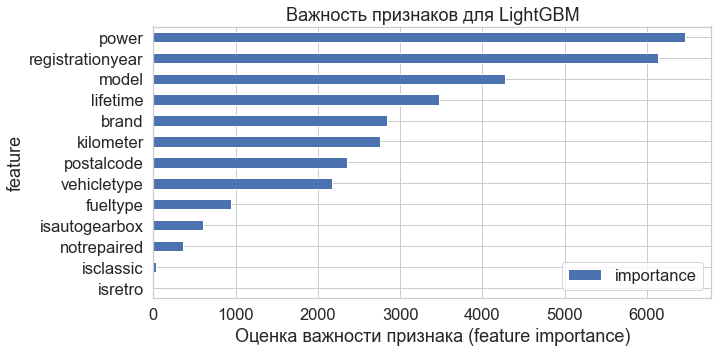

In [133]:
fi_gbm = pd.DataFrame(data ={'feature': X_train_lgb.columns, 'importance': model_lgb.feature_importances_})
fi_gbm.sort_values('importance').plot(kind='barh', x = 'feature', figsize=(10, 5))
plt.title('Важность признаков для LightGBM')
plt.xlabel('Оценка важности признака (feature importance)')
plt.legend(loc="lower right");

В LightGBM по-другому распределена важность признаков. Мощность двигателя и год регистрации поменялись местами, а model вошла в топ-3. Дополнительный признак lifetime имеет ещё более высокую важность, а вот принадлежность к классике или ретро также заняли последние места.

Подготовим отчет по собранным данным о работе моделей:

In [134]:
report = {'model' : ['Random forest', 'Catboost', 'LightGBM'], 
          'RMSE_CV' : [RMSE_FOREST_VALID, RMSE_CATBOOST_VALID, RMSE_LIGHTGBM_VALID],
         'RMSE_test' : [RMSE_FOREST_TEST, RMSE_CATBOOST_TEST, RMSE_LIGHTGBM_TEST],
         'fit_time' : [FIT_TIME_FOREST, FIT_TIME_CATBOOST, FIT_TIME_LIGHTGBM],
         'predict_time' : [PREDICT_TIME_FOREST, PREDICT_TIME_CATBOOST, PREDICT_TIME_LIGHTGBM]}

report = pd.DataFrame(data=report).round(2).sort_values('RMSE_test')

In [135]:
report

,model,RMSE_CV,RMSE_test,fit_time,predict_time
1,Catboost,1467.00,1447.78,212.00,0.41
2,LightGBM,1489.00,1465.80,1.96,0.44
0,Random forest,1544.31,1512.22,345.00,2.97


Лучшим по качеству снова оказался Catboost, однако у LightGBM отрыв совсем небольшой, а по времени обучения этот алгоритм вне конкуренции.

Попробуем улучшить качество предикта простым методом - усреднение ответов каждой модели.

In [136]:
predicted_mean = (predicted_forest + predicted_catboost + predicted_lgb) / 3

In [137]:
RMSE_ALL_MODELS_MEAN = mean_squared_error(y_test_lgb, predicted_mean)**0.5

In [138]:
RMSE_ALL_MODELS_MEAN

1420.7400753513655

Интересно, что это позволило улучшить скор. Дальнейшее изучение этого вопроса ведёт к генерации метапризнаков и метаалгоритмов (Стекинг, блендинг). Сохраним показатели работы объединенной модели чтобы добавить в отчет:

In [139]:
top3_model_mean = {'model' : 'Top3_model_mean', 
          'RMSE_CV' : [0],
         'RMSE_test' : [RMSE_ALL_MODELS_MEAN],
         'fit_time' : [report['fit_time'].sum()],
         'predict_time' : [report['predict_time'].sum()]}

top3_model_mean = pd.DataFrame(data=top3_model_mean).round(1)

Добавим данные первого исследования для сравнения:

In [140]:
old_results = {'model' : ['Tree_v1', 'Random Forest_v1', 'Linear Regression_v1', 'Caiboost_v1', 'LightGBM_v1', 'XGBoost_v1',
                          'Catboost_raw_data'], 
          'RMSE_CV' : [1754, 1578, 2597, 1539, 1550, 1571, 1672],
         'RMSE_test' : [1727, 1533, 2596, 1498, 1505, 1609, 1686],
         'fit_time' : [6.6, 159, 5.6, 226, 3, 85, 437],
         'predict_time' : [0.6, 4.6, 0.6, 0.5, 0.4, 0.9, 0.8]}

old_results = pd.DataFrame(data=old_results).round(1).sort_values('RMSE_test')

Объединим данные с текущим исследованием. Данные из первой версии проекта будут с префиксом v1:

In [141]:
final_report = pd.concat([report, old_results, top3_model_mean], ignore_index=True)

Изменим типы для удобства воспрития:

In [142]:
final_report['RMSE_CV'] = final_report['RMSE_CV'].astype('int')
final_report['RMSE_test'] = final_report['RMSE_test'].astype('int')
final_report['fit_time'] = final_report['fit_time'].round(1)
final_report['predict_time'] = final_report['predict_time'].round(1)
final_report = final_report.sort_values('RMSE_test')

Выведем итоговую версию отчета по всем моделям:

In [143]:
final_report

,model,RMSE_CV,RMSE_test,fit_time,predict_time
10,Top3_model_mean,0,1420,559.0,3.8
0,Catboost,1467,1447,212.0,0.4
1,LightGBM,1489,1465,2.0,0.4
3,Caiboost_v1,1539,1498,226.0,0.5
4,LightGBM_v1,1550,1505,3.0,0.4
2,Random forest,1544,1512,345.0,3.0
5,Random Forest_v1,1578,1533,159.0,4.6
6,XGBoost_v1,1571,1609,85.0,0.9
7,Catboost_raw_data,1672,1686,437.0,0.8
8,Tree_v1,1754,1727,6.6,0.6


## Общий вывод

После упрощения подхода к предобработке и добавления новых признаков удалось улучшить качество работы каждой модели по сравнению с первой версией проекта. При этом количество очищенных данных находится примерно на одном уровне. Кроме того, усреднив результаты новых моделей, удалось достичь ещё большего качества на тестовой выборке. Однако, усреднение может быть не применимо в бизнесе из-за ограничений по времени обучения и времени предикта, так как требуется проработка сразу нескольких моделей.

Основная рекомендация для бизнеса остаётся прежней:

Необходимо создать и настроить выпадающие списки и шкалы выбора параметров автомобилей так, чтобы пользователь не вводил их сам с клавиатуры. Сначала пользователь выбирает бренд, затем модель, а затем подтягиваются возможные варианты для выбора мощности мотора, типа кузова, коробки передач, типа топлива. Эти выпадающие списки создать не так сложно, как правило для каждой модели существует 2-3 варианта возможных двигателя (для каждого двигателя заранее известна его мощность), 2 варианта коробки, 1-2 типа топлива и тд. Ключевая идея в том, чтобы не позволять пользователю вводить всякую дурню с клавиатуры или оставлять важные поля пустыми. Без её реализации не получится настроить точную модель оценки авто. Кроме того, это необходимо не только для построения модели оценки, но и для того чтобы объявление пользователя могло находить в поиске приложения как можно больше людей по разным фильтрам. Больше просмотров объявления -> больше потенциальных клиентов -> быстрее и возможно дороже пользователь продаст авто -> больше удовлетворенность от использования сервиса.

Можно предложить заказчику использовать в работе 4 модели:

In [144]:
final_report.query('model=="Catboost_raw_data" or model=="Catboost" or model=="Top3_model_mean" or model=="LightGBM"')

,model,RMSE_CV,RMSE_test,fit_time,predict_time
10,Top3_model_mean,0,1420,559.0,3.8
0,Catboost,1467,1447,212.0,0.4
1,LightGBM,1489,1465,2.0,0.4
7,Catboost_raw_data,1672,1686,437.0,0.8


<br><b>Catboost_raw_data</b>
* Работает с сырыми данными без какой-либо обработки, не нужно использовать рекомендованный вариант при разработки приложения
* Точность предсказания, время обучения, время прогнозирования намного хуже, чем у других моделей
* Не приведёт к потери клиентов в краткосрочном периоде (пока им не надоест пользоваться не современным приложением и видеть неточные оценки).

<br><b>Новые Catboost и LightGBM</b>
* Очень высокая точность предсказания
* Самая высокая скорость предсказания среди всех моделей
* у LightGBM также невероятно высокая скорость обучения
* Работает с серьезной предобработкой данных
* Требует 100% следования рекомендации по улучшению приложения
* В краткосрочном периоде может привести к потери части клиентов (около 3%)
* В долгосрочном периоде способствует росту клиентской базы и дальнейшему улучшения как самого сервиса, так и качества прогнозирования

<br><b> Top3_model_mean </b>
* Самая высокая точность предсказания среди всех моделей
* Для реализации необходимо усреднить результаты работы трёх новых моделей Catboost, LightGBM, RF поэтому модель имеет плохие показатели времени обучения и скорости предикта
* Можно использовать если указанная в таблице скорость является приемлимой

Все подобранные выше обученные модели могут быть полезны бизнесу в зависимости от ситуации: возможно/не возможно разработать приложение, опираясь на рекомендацию, какая скорость обучения/предикта устроит, есть ли возможность использовать рекомендованную предобработку.